In [2]:
from __future__ import print_function

import argparse
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import QMNIST
from tqdm import tqdm_notebook as tqdm

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=0.20)
            )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout2d(0.25)
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
        )

        self.fc = nn.Sequential(
            #全結合層
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.Linear(128, 10)
        )
 

    def forward(self, x):  

        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        out = F.softmax(out)
        return out


In [4]:
def train_model(net, dataloders_dict, criterion, optimizer, num_epochs):
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    #初期設定
    #GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス", device)
    #モデルをGPUへ
    net.to(device)
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark = True
    #epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-----------------------------------')

        #epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() #モデルを訓練モードに
            else:
                net.eval() #モデルを検証モードに
            epoch_loss = 0.0 #epochの損失0
            epoch_corrects = 0 #epochの正解数
            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloders_dict[phase]):
                #optimizerを初期化
                optimizer.zero_grad()
                #順伝搬(forward)計算
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)#損失を計算
                    _, preds = torch.max(outputs, 1) #ラベルを予測
                    #訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    #イテレーション結果の計算
                    #lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    #正解の合計数を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            #epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloders_dict[phase].dataset)
            print('{} Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            if phase == 'train':
                train_acc_list.append(epoch_acc)
                train_loss_list.append(epoch_loss)
            else:
                val_acc_list.append(epoch_acc)
                val_loss_list.append(epoch_loss)
    return val_loss_list,train_loss_list, val_acc_list, train_acc_list

In [45]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image

import os.path as osp
import glob


#入力画像の処理を行う
#訓練時と推論時で処理が異なる

class ImageTransform():

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(resize), #リサイズ
                # transforms.RandomRotation(degrees=20), #ランダムに回転
                transforms.ToTensor(), #テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize), #リサイズ
                transforms.ToTensor(), #テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        pahes:'train' or 'val'
        """
        return self.data_transform[phase](img)

class testDataset(data.Dataset):
    '''
    file_list : リスト
        画像パス
    transform: object
        前処理クラスのインスタンス
    phase : 学習化テストか設定する
    '''
    def __init__(self,transform=None, phase='val'):

        self.transform = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(28),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, ), (0.5, ))
                         ])
        self.phase = phase#train or val の指定

        rootpath = "../data/tranings/"
        target_path = osp.join(rootpath+'**/*.png')
    
        path_list = []

        for path in glob.glob(target_path):
            path_list.append(path)

        self.file_list = path_list

    def __len__(self):
        #画像の枚数を返す
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルの取得
        '''
        #index番目の画像をロード
        img_path = self.file_list[index]
        label = img_path[17]

        img = Image.open(img_path).convert('RGBA')
        r, g, b, a = img.split()
        img = np.asarray(a)
        img = Image.fromarray(img)
        
        img_transformed = self.transform(
            img
        )

        label = torch.tensor(int(label), dtype=torch.int64)
        
        return img_transformed, label

In [46]:
import random
seed = 42
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)

import tensorflow as tf
import torch.utils.data as data
from torch.utils.data import DataLoader

rotation_range=10
zoom_range = 0.10
width_shift_range=0.1 
height_shift_range=0.1
train_transform = transforms.Compose([
#      transforms.Resize(36)
#      transforms.RandomCrop(28),
     transforms.RandomAffine(degrees=rotation_range, translate=(width_shift_range, height_shift_range), 
    scale=(1 - zoom_range, 1 + zoom_range)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
     ])
# test_transform = transforms.Compose([
#     transforms.Resize(32)
#      transforms.CenterCrop(28),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))
#      ])


trainset = QMNIST(root='./',
                 train=True,
                 download=True,
                 transform=train_transform)


trainloader = DataLoader(trainset,
                         batch_size=1024,
                         shuffle=True,
                         num_workers=2)
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 32, shuffle=False)

dataloders_dict = {"train": trainloader, "val": testloader}

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_loss, train_loss, val_acc, train_acc = train_model(model, dataloders_dict, criterion, optimizer, num_epochs=20)
torch.save(model.state_dict(), "mnist_cnn.pth")

使用デバイス cuda:0
Epoch 1/20
-----------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



train Loss:1.8268 Acc: 0.6885



val Loss:1.9116 Acc: 0.6350
Epoch 2/20
-----------------------------------



train Loss:1.5411 Acc: 0.9427



val Loss:1.7175 Acc: 0.7570
Epoch 3/20
-----------------------------------



train Loss:1.5120 Acc: 0.9611



val Loss:1.7123 Acc: 0.7510
Epoch 4/20
-----------------------------------



train Loss:1.5021 Acc: 0.9677



val Loss:1.6921 Acc: 0.7760
Epoch 5/20
-----------------------------------


KeyboardInterrupt: 

# 検証

In [36]:
model = Net()
model.load_state_dict(torch.load("../model/mnist_cnn.pth"))
model.to('cuda')
model.eval()

Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=

In [37]:
class valDataset(data.Dataset):
    def __init__(self):
        path = "../data/tests/"
        self.label_dict = []
        with open('../data/tests.txt') as f:
            for line in f:
                line = line.replace("\n", "")
                name, label = line.split("/")
                self.label_dict.append(("../data/tests/" + name, int(label)))
        self.transform = transforms.Compose([
                        transforms.Resize(40),
                        transforms.CenterCrop(28),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, ), (0.5, ))
                         ])
    def __len__(self):
        #画像の枚数を返す
        return len(self.label_dict)
    
    def __getitem__(self, index):
        img_path, label = self.label_dict[index]
        
        img = Image.open(img_path).convert('RGBA')
        r, g, b, a = img.split()
        img = np.asarray(a)
        img = Image.fromarray(img)
        
        img_transformed = self.transform(
            img
        )

        label = torch.tensor(int(label), dtype=torch.int64)
        
        return img_transformed, label
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1000, shuffle=False)
# testloader =  torch.utils.data.DataLoader(valDataset(), batch_size = 100, shuffle=False)
pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    pred.append(predicted)
    label.append(l)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
# label[0].to('cpu').numpy()
# pred[0].to('cpu').numpy()

# コンフュージョンマトリックス

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


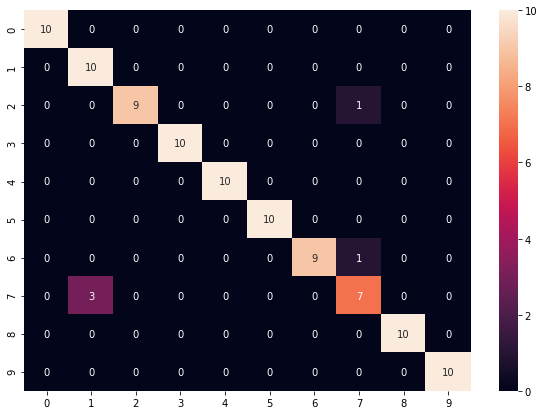

In [40]:
testloader =  torch.utils.data.DataLoader(valDataset(), batch_size = 100, shuffle=False)
pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    pred.append(predicted)
    label.append(l)
confusion = confusion_matrix(label[0].to('cpu').numpy(), pred[0].to('cpu').numpy())
df_cm = pd.DataFrame(confusion,index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

tensor(906)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


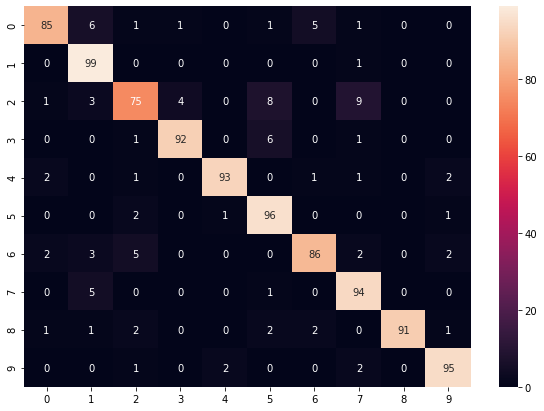

In [44]:
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1000, shuffle=False)

pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    pred.append(predicted)
    label.append(l)
    print(torch.sum(predicted.to("cpu") == l.data))
confusion = confusion_matrix(label[0].to('cpu').numpy(), pred[0].to('cpu').numpy())
df_cm = pd.DataFrame(confusion,index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# test code

In [137]:
import os
import cv2
import sys
import numpy as np
from PIL import Image

In [80]:
img = Image.open("data/tests/25784885.png").resize((28, 28)).convert('RGBA')
img

In [81]:
r, g, b, a = img.split()
img = np.asarray(a)

In [82]:
image = img

In [83]:
inputs = torch.tensor(image, dtype=torch.float32)

In [84]:
inputs.shape

torch.Size([28, 28])

In [94]:
model = Net()
model.load_state_dict(torch.load("./model/mnist_cnn.pth"))
model.to('cuda')

Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=

In [86]:
inputs = test_transform(image)
inputs = inputs[None, ...]
inputs = inputs.to('cuda')

In [87]:
model.eval()
output = model(inputs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [88]:
_, predicted = torch.max(output.data, 1)

In [89]:
predicted.item()

7